# Quickstart

Consider a simple image deconvolution problem, where we want to find a clean image $x$ given the blurred observation $y$ that minimizes the following objective function:

$$
\arg \min_x { \frac{1}{2} |Dx - y|^2_2 + g(x) },
$$

where $g(x)$ denotes an implicit plug-and-play denoiser prior. 

In [1]:
from dprox import *
from dprox.utils import *
from dprox.contrib import *

We can solve this problem in ∇-Prox with the intuitive code that follow the math:

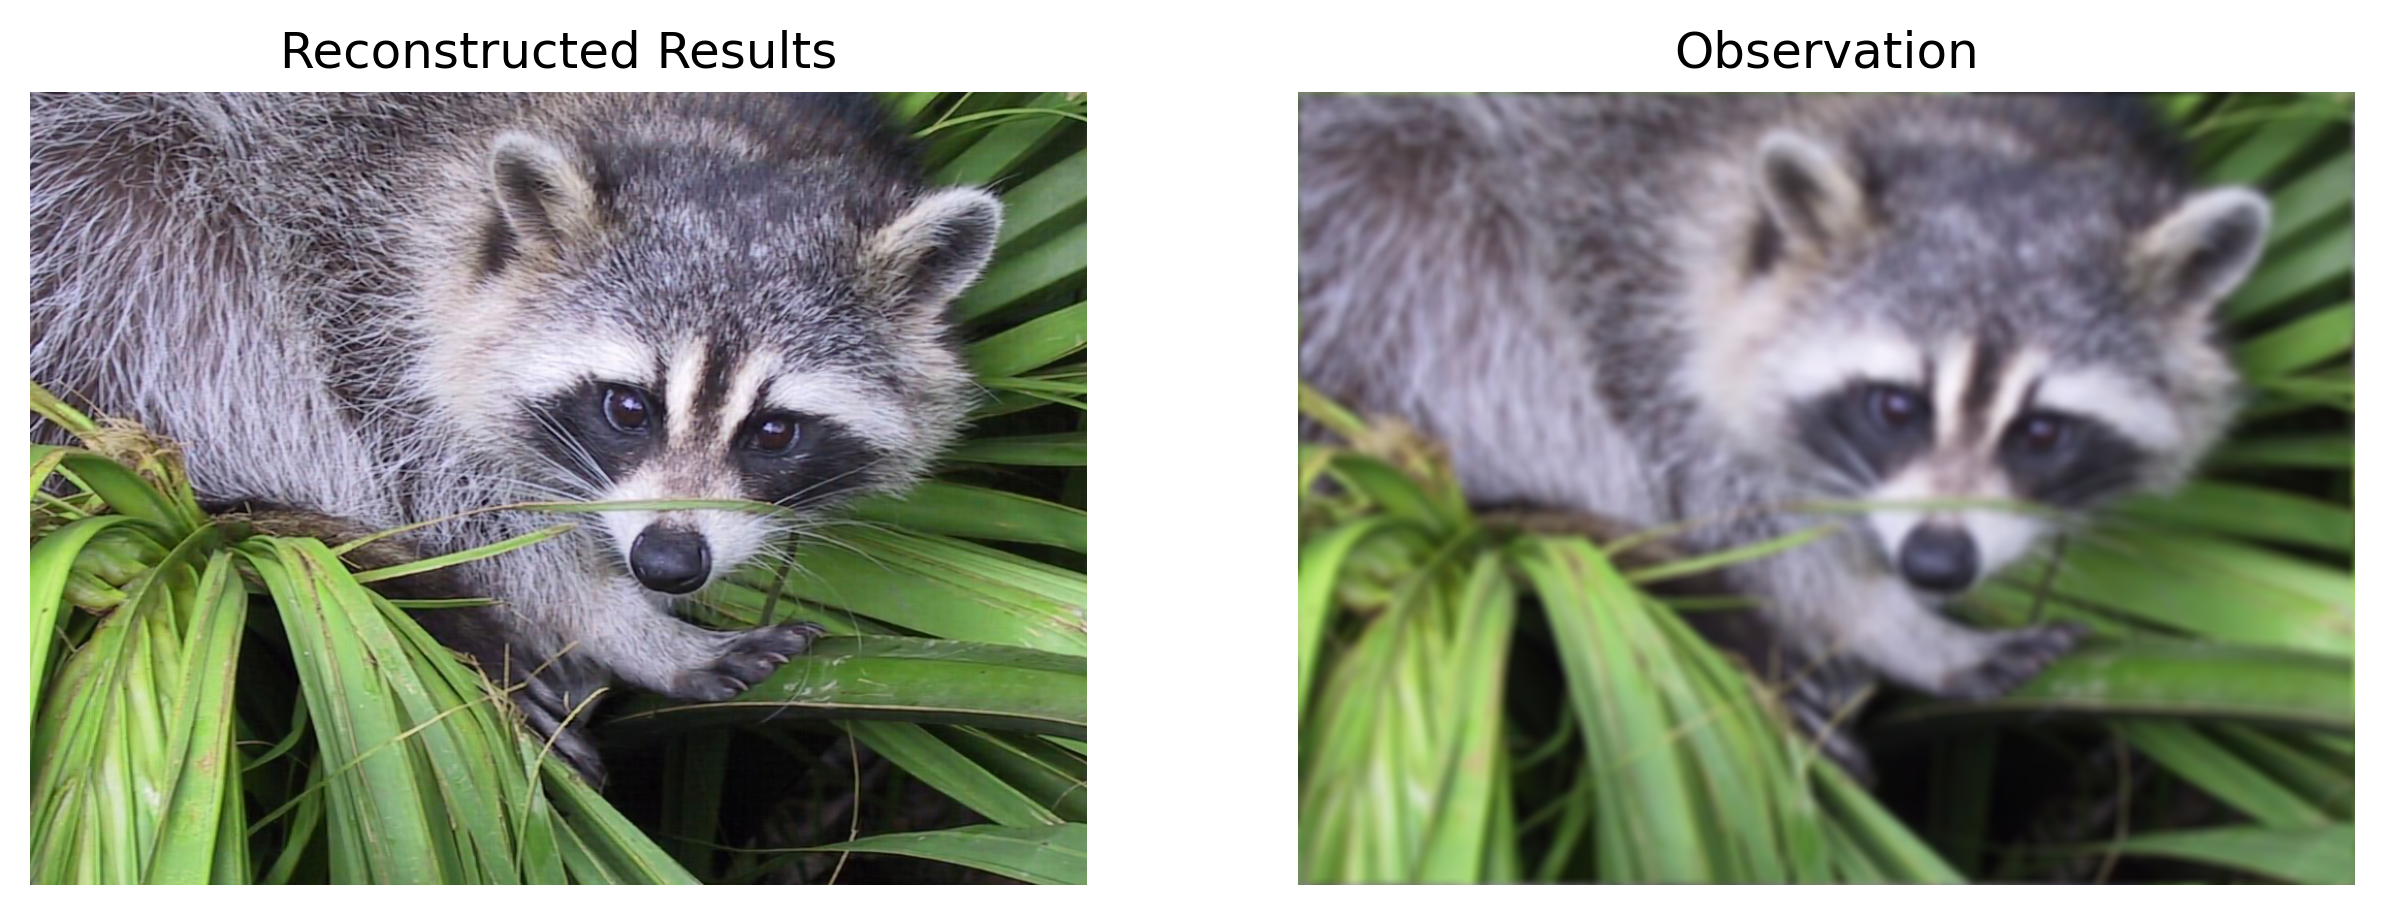

In [2]:

img = sample()
psf = point_spread_function(15, 5)
b = blurring(img, psf)

x = Variable()
data_term = sum_squares(conv(x, psf) - b)
reg_term = deep_prior(x, denoiser='ffdnet_color')
prob = Problem(data_term + reg_term)

out = prob.solve(method='admm', x0=b)
imshow(out, b, titles=['Reconstructed Results', 'Observation'])

## End-to-end bi-level optimization

> The above task is a simple task that only involves solving an optimization with proximal algorithm. With ∇-Prox, we actually support more possiblities.

In [3]:
from dprox.contrib.optic import *

### Define Solver

As a specific example, we consider end-to-end computational optics that jointly optimize a diffractive optical element (DOE) and an image reconstruction algorithm, where the observation $y$ is obtained by convolving a clear image $x$ by the point spread function (PSF) of DOE as,

$$
    y =  D\left(x;\, \theta_{DOE} \right) + \epsilon, 
$$

where $D(\cdot; \theta_{DOE})$ indicates a shift-invariant convolution process with an optical kernel, i.e., PSF, derived from a DOE image formation model parameterized by $\theta_{DOE}$, and $\epsilon$ is measurement noise, e.g., Poissionian-Gaussian noise. 

This process could be written in ∇-Prox as follow,

In [4]:
x = Variable()
PSF = Placeholder()
y = conv_doe(x, PSF, circular=True)


To reconstruct the target image $x$ from noise-contaminated measurements $y$, we minimize the sum of a data-fidelity $f$ and regularizer term $r$ as

$$
    \mathop{\mathrm{min}}_{x \in \mathbb{R}^n} ~ f \left( D\left(x;\, \theta_{DOE} \right), b \right) + r \left(x ; \, \theta_r \right).
$$

which could be written in ∇-Prox as follow,


In [5]:

b = Placeholder()
data_term = sum_squares(y, b)
reg_term = deep_prior(x, denoiser='ffdnet_color')
objective = data_term + reg_term

To obtain the proximal solver, we use the `compile` primitive.

In [6]:
solver = compile(objective, method='admm')

### Define Optic Model

We could define the optic model and visualize the PSF of the vanilla Fresnel lens.

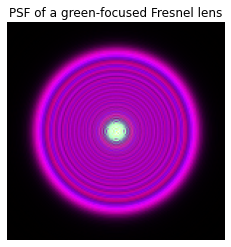

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
doe_model = build_doe_model().to(device)
psf = doe_model.get_psf()
psf_original = crop_center_region(normalize_psf(to_ndarray(psf, debatch=True), clip_percentile=0.01))
imshow(psf_original, titles=["PSF of a green-focused Fresnel lens"])

To enable the training, we need some setup for the trainable parameters and the forward process.

Here, the trainable parts are the **optic doe model** and the **hyparamters** of the proximal algorithm.

In [8]:
max_iter = 10
sigma = 7.65 / 255.
rhos, lams = log_descent(49, 7.65, max_iter, sigma=max(0.255 / 255, sigma))
doe_model.rhos = nn.parameter.Parameter(rhos)
doe_model.lams = nn.parameter.Parameter(lams)

solver = specialize(solver, method='unroll', max_iter=max_iter)

def step_fn(gt):
    gt = gt.to(device).float()
    psf = doe_model.get_psf()
    inp = img_psf_conv(gt, psf, circular=True)
    inp = inp + torch.randn(*inp.shape, device=inp.device) * sigma
    b.value = inp
    PSF.value = psf

    out = solver.solve(x0=inp, rhos=doe_model.rhos, lams={reg_term: doe_model.lams.sqrt()})
    return gt, inp, out


### Training
Once we have properly defined the forward model and the trainable paramters, the training could be easily done with **only one line of code**.

In [9]:
train(model=doe_model, step_fn=step_fn, dataset='BSD500', epochs=2)

Epcoh[0]:   0%|          | 0/100 [00:00<?, ?it/s]/home/laizeqiang/miniconda3/envs/torch1.10/lib/python3.7/site-packages/torch/autograd/__init__.py:175: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/Copy.cpp:239.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass
Epcoh[0]:   1%|          | 1/100 [00:00<01:05,  1.51it/s, loss=0.0104, psnr=19.8388]

Epcoh[1]: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s, loss=0.0012, psnr=29.9019]


With only 2 minutes of training, we could find an interesting optimized PSF that drastically differs from previous one. This also differs from the optimized one of other methods, see [computational optics notebook](https://github.com/princeton-computational-imaging/Delta-Prox/blob/main/notebooks/computational_optics.ipynb) for details.

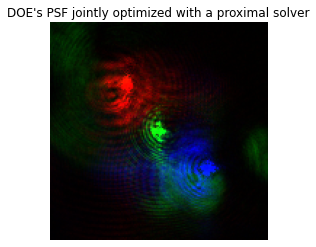

In [10]:
psf = doe_model.get_psf()
psf_dprox = crop_center_region(normalize_psf(to_ndarray(psf, debatch=True), clip_percentile=0.01))
imshow(psf_dprox, titles=["DOE's PSF jointly optimized with a proximal solver"])


The phase pattern we learn focuses the three wavelength bands as highly chromatic PSFs for each channel, that is, the red, green, and blue PSFs only focus on the specific channel while spreading out energy for other wavelengths over the entire sensor. 

By spatially separating the corresponding phase patterns, our co-designed network can find these chromatic PSFs. As such, $\nabla$-Prox allows us to find a novel point in the design space -- turning an out-of-focus deconvolution problem into a transverse chromatic alignment problem. 🙀